In [1]:
! which python

/Users/intern/opt/anaconda3/envs/abtest/bin/python


In [2]:
import pandas as pd

import os

# hypothesis test
from scipy.stats import ttest_ind
from scipy import stats

# bayesian
#import theano
#theano.config.gcc.cxxflags = '-isysroot /Library/Developer/CommandLineTools/SDKs/MacOSX.sdk -Wno-c++11-narrowing'
import pymc3 as pm
import arviz as az

## viz
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
"""

    where am i?

"""

PATH = os.getcwd() + '/'
data_path = PATH + 'data/'

print(f'PATH: {PATH}')
print(f'data_path: {data_path}')

PATH: /Users/intern/Documents/AB test/
data_path: /Users/intern/Documents/AB test/data/


In [4]:
"""

    load data
    
    A <- control group
    B <- treatment group

"""

data = pd.read_csv( data_path + 'test_bttc.csv')
data2 = pd.read_csv(data_path + 'test_bttc_20210710.csv')
data = data.append(data2)
data = data.dropna()

print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1917 entries, 0 to 1040
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   loan_id  1917 non-null   int64 
 1   group    1917 non-null   object
 2   answer   1917 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 59.9+ KB
None


,loan_id,group,answer
0,54729,no_model,0
1,52898,no_model,1
2,46282,no_model,1
3,47997,no_model,1
4,55271,no_model,1


In [5]:
"""

    segmentation

"""
import plotly.io as pio
pio.renderers.default='iframe'

fig = px.histogram(data, x='group')
fig.update_layout(
    title_text='experiments'
)
fig.show()

#experiment_list = sorted(list( data['group'].unique() ))
#print(f'\nexperiments: {experiment_list}')

In [6]:
"""

    conversion rates by experiment

"""

aux_a = data[ data['group'] == 'model' ]
aux_b = data[ data['group'] == 'no_model' ]

print(f'A conversion rate: {aux_a["answer"].mean(): .3%}')
print(f'B conversion rate: {aux_b["answer"].mean(): .3%}')

A conversion rate:  44.068%
B conversion rate:  47.414%


Text(0.5, 1.0, 'Histogram of Prior Conversion Rates')

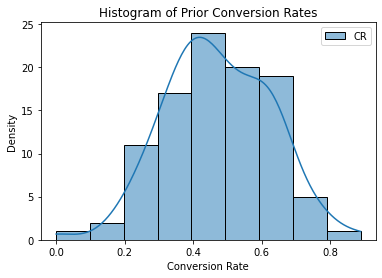

In [7]:
#prior_data = pd.read_csv('prior_data_conversions.csv')
x = np.linspace(0,1,1000)
partitions = np.array_split(aux_b, 100)
rates = []
for partition in partitions:
    rates.append(partition['answer'].mean())
_, ax = plt.subplots()
sns.histplot(rates, kde=True, label='CR')
ax.legend()
ax.set_xlabel('Conversion Rate')
ax.set_ylabel('Density')
ax.set_title('Histogram of Prior Conversion Rates')

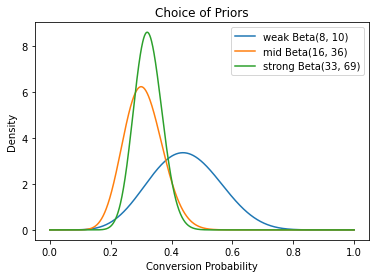

In [8]:
from scipy.stats import beta
_, ax = plt.subplots(1, 1)
x = np.linspace(0,1,1000)
beta_weak = beta(8, 10)
beta_mid = beta(16, 36)
beta_strong = beta(33, 69)
ax.plot(x, beta_weak.pdf(x), label=f'weak Beta({8}, {10})')
ax.plot(x, beta_mid.pdf(x), label=f'mid Beta({16}, {36})')
ax.plot(x, beta_strong.pdf(x), label=f'strong Beta({33}, {69})')
ax.set_xlabel('Conversion Probability')
ax.set_ylabel('Density')
ax.set_title('Choice of Priors')
ax.legend()

/Users/intern/opt/anaconda3/envs/abtest/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning:

The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.



Text(0, 0.5, 'Frequency')

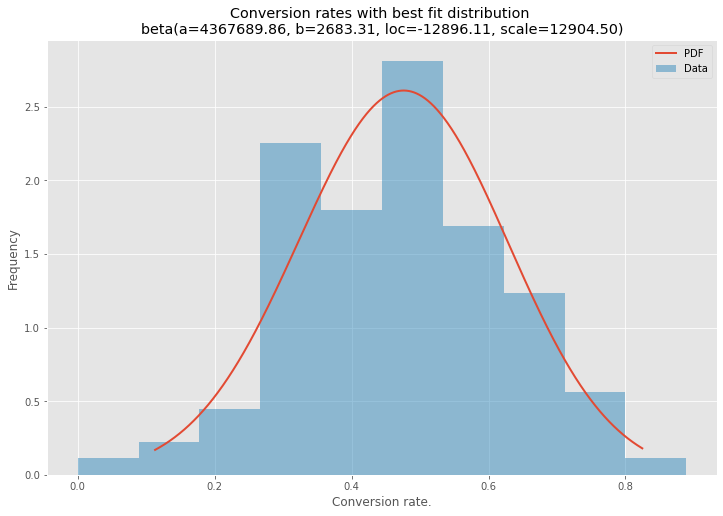

In [9]:
import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels as sm
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (12.0, 8.0)
matplotlib.style.use('ggplot')

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

prior = pd.Series(rates)
params = stats.beta.fit(prior)
best_dist = getattr(st, stats.beta.name)
# Make PDF with best params 
pdf = make_pdf(stats.beta, params)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
prior.plot(kind='hist', alpha=0.5, density=True, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, params)])
dist_str = '{}({})'.format(stats.beta.name, param_str)

ax.set_title(u'Conversion rates with best fit distribution \n' + dist_str)
ax.set_xlabel(u'Conversion rate.')
ax.set_ylabel('Frequency')

In [10]:
print(params)

(4367689.85544764, 2683.313851681097, -12896.107122941092, 12904.503346067751)


In [11]:
"""

    Welch’s t-test
    
    h_0: A is equal to B
    -- h_1: B is better than A
    
    given that h_0 is true, the chance that we get our observed or an even more extreme outcome is at most "p-value"
    
    if p-value > 0.5, we keep the null hypothesis

"""

#print(f'p-value: {ttest_ind(blue_conversions, red_conversions, equal_var=False, alternative="less").pvalue:.1%}')

aux_a = data[ data['group'] == 'model' ]
aux_b = data[ data['group'] == 'no_model' ]
    
a_conversion = aux_a[ 'answer' ]
b_conversion = aux_b[ 'answer' ]
    
stat, p_value = ttest_ind( a_conversion, b_conversion, equal_var=False, alternative='less')
print('stat=%.3f, p=%.3f' % (stat, p_value))    
#print(f'p-value: {p_value}')
    
if p_value > 0.05:
    print('Probably the same distribution')
else:
    print('Probably different distributions')

stat=-0.852, p=0.198
Probably the same distribution


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_rate, a_rate]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


Probability that a is better: 19.7%. 



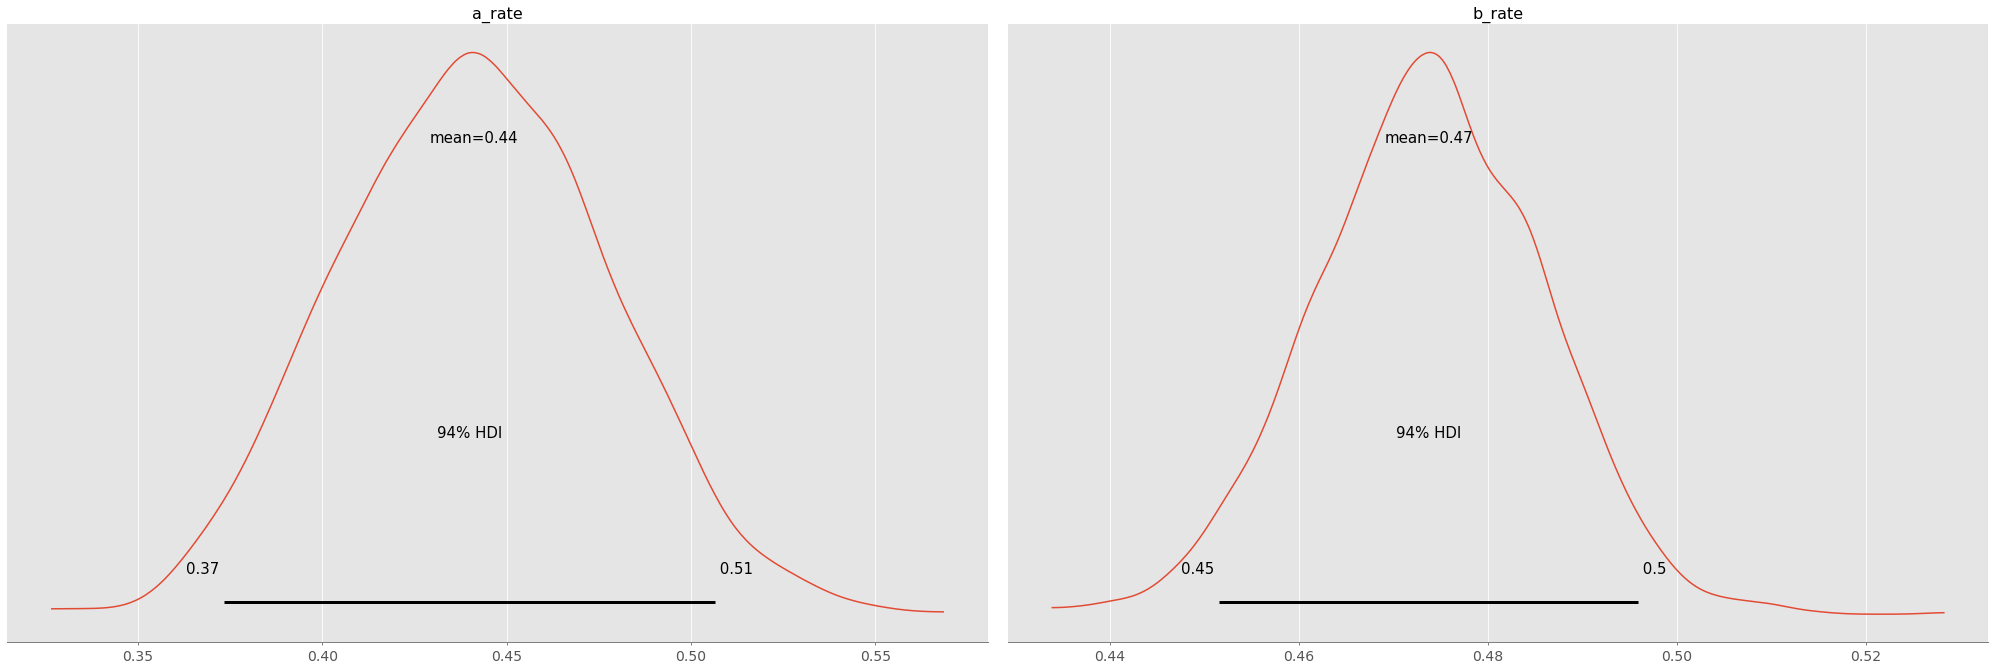

In [12]:
"""

    Byesian Approach
    
    Using Beta Distribution since the conversion rates are between 0 and 1
    
"""

aux_a = data[ data['group'] == 'model' ]
aux_b = data[ data['group'] == 'no_model' ]
    
a_conversions = aux_a[ 'answer' ]
b_conversions = aux_b[ 'answer' ]
    
with pm.Model():

    a_rate = pm.Beta('a_rate', 8, 10)
    b_rate = pm.Beta('b_rate', 8, 10)

    a_obs = pm.Bernoulli('a_obs', a_rate, observed = a_conversions)
    b_obs = pm.Bernoulli('b_obs', b_rate, observed = b_conversions)

    trace = pm.sample(return_inferencedata=True)
        
    az.plot_posterior(trace)
        
    a_rate_samples = trace.posterior['a_rate'].values
    b_rate_samples = trace.posterior['b_rate'].values
        
    print(f'Probability that a is better: {(a_rate_samples > b_rate_samples).mean():.1%}. \n')

In [13]:
fig = go.Figure(go.Bar(
        x=[(a_rate_samples > b_rate_samples).mean() * 100, (a_rate_samples < b_rate_samples).mean() * 100],
        y=['Probability that a is better', 'Probability that b is better'], orientation='h'))
fig.show()

In [14]:
def winner():
    if (a_rate_samples > b_rate_samples).mean()*100 > 95:
            print('A is the Winner')
    if (a_rate_samples < b_rate_samples).mean()*100 > 95:
            print('B is the Winner')
    else: 
        print('No winner has been declared yet. (Based on 95% significance level)')
winner()

No winner has been declared yet. (Based on 95% significance level)


Text(0.5, 1.0, 'absolute difference in succes rates between A and B')

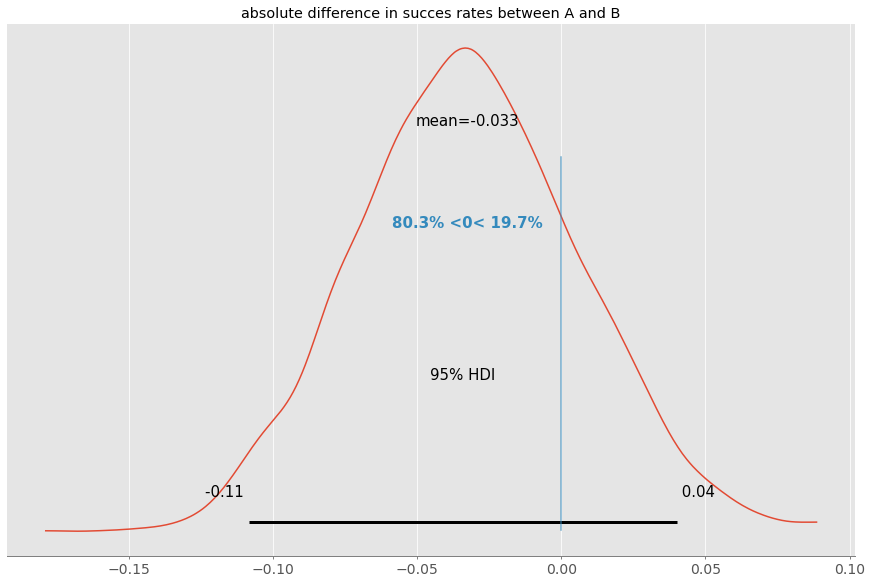

In [15]:
#takes a few seconds
t = np.array(a_rate_samples - b_rate_samples)
#shows distribution of absolute difference between treatments
#shows % change of being smaller of bigger than 0
#shows 95% probability interval of the parameter

az.plot_posterior(t, ref_val=0, hdi_prob=0.95, kind='kde')
plt.title('absolute difference in succes rates between A and B')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_rate, a_rate]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


Probability that a is better: 100.0%. 



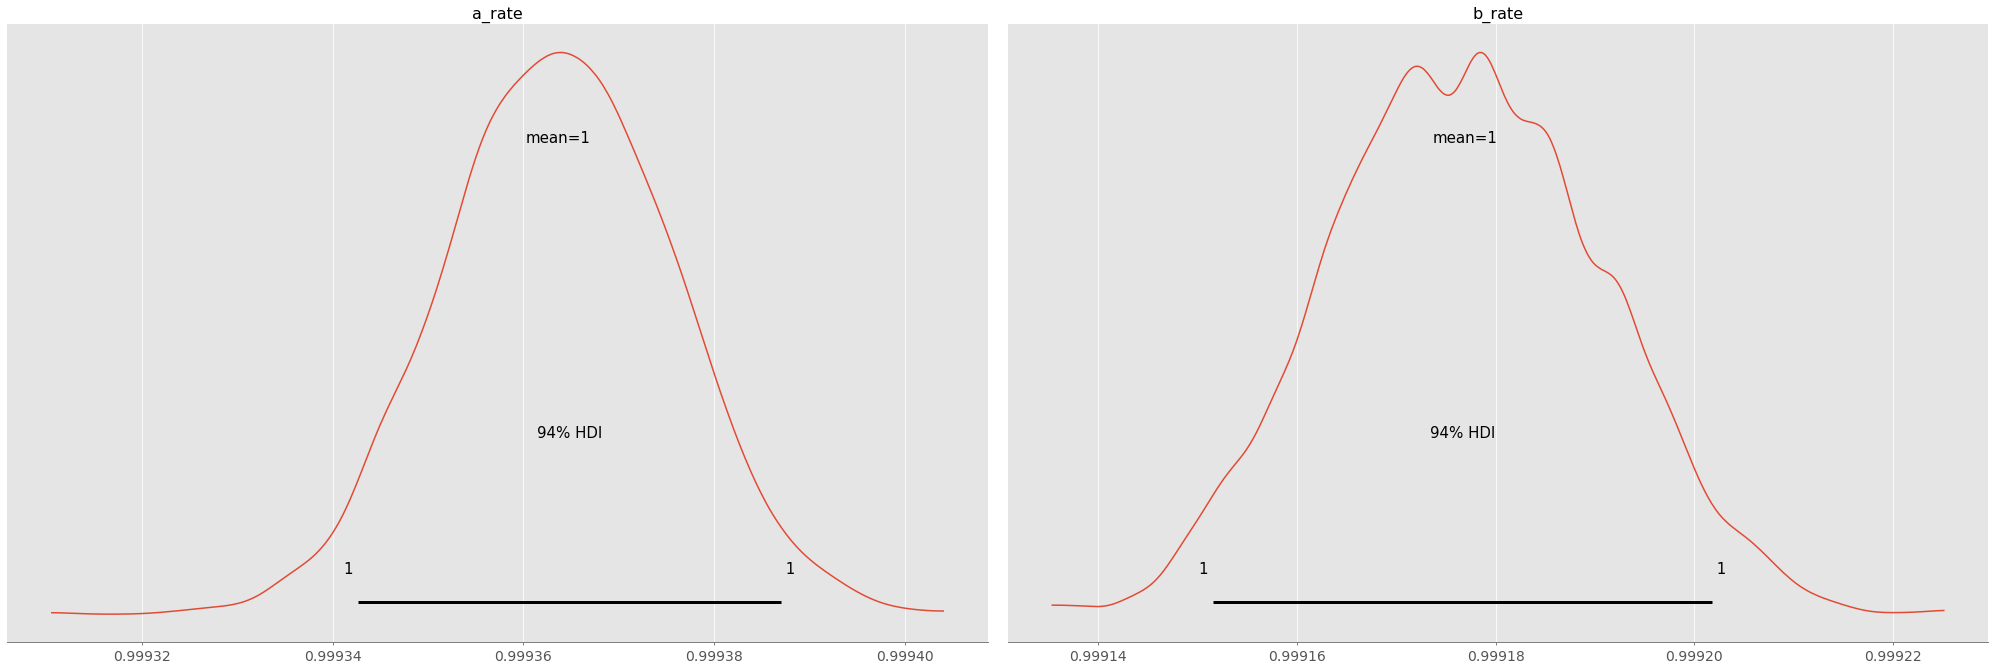

In [16]:
"""

    Byesian Approach
    
    Using Beta Distribution since the conversion rates are between 0 and 1
    
"""

aux_a = data[ data['group'] == 'model' ]
aux_b = data[ data['group'] == 'no_model' ]
    
a_conversions = aux_a[ 'answer' ]
b_conversions = aux_b[ 'answer' ]
    
with pm.Model():

    a_rate = pm.Beta('a_rate', params[0], params[1])
    b_rate = pm.Beta('b_rate', params[0], params[1])

    a_obs = pm.Bernoulli('a_obs', a_rate, observed = a_conversions)
    b_obs = pm.Bernoulli('b_obs', b_rate, observed = b_conversions)

    trace = pm.sample(return_inferencedata=True)
        
    az.plot_posterior(trace)
        
    a_rate_samples = trace.posterior['a_rate'].values
    b_rate_samples = trace.posterior['b_rate'].values
        
    print(f'Probability that a is better: {(a_rate_samples > b_rate_samples).mean():.1%}. \n')

In [17]:
fig = go.Figure(go.Bar(
        x=[(a_rate_samples > b_rate_samples).mean() * 100, (a_rate_samples < b_rate_samples).mean() * 100],
        y=['Probability that a is better', 'Probability that b is better'], orientation='h'))
fig.show()

In [18]:
def winner():
    if (a_rate_samples > b_rate_samples).mean()*100 > 95:
            print('A is the Winner')
    if (a_rate_samples < b_rate_samples).mean()*100 > 95:
            print('B is the Winner')
    else: 
        print('No winner has been declared yet. (Based on 95% significance level)')
winner()

A is the Winner
No winner has been declared yet. (Based on 95% significance level)


In [19]:
#takes a few seconds
t = np.array(a_rate_samples - b_rate_samples)

Text(0.5, 1.0, 'absolute difference in succes rates between A and B')

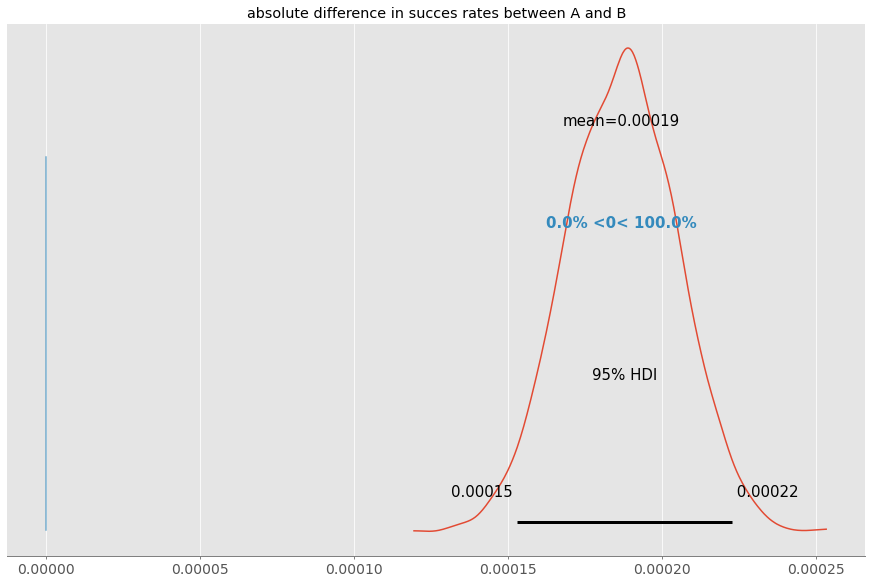

In [20]:
#shows distribution of absolute difference between treatments
#shows % change of being smaller of bigger than 0
#shows 95% probability interval of the parameter

az.plot_posterior(t, ref_val=0, hdi_prob=0.95, kind='kde')
plt.title('absolute difference in succes rates between A and B')